# A Quick Note on GPU Accuracy and Double Precision

Often when optimizing simulation software, we run into a classic roadblock:  *Floating point precision is not accurate enough, we must use double precision.*

Of course, there are many instances in real physical problems where indeed, a solution requires double precision computation.  However, we should be careful not to fall into a trap - the performance benefits of using 32bit vs 64bit datatypes is **significant**

Particularly on gpus, where memory and bandwidth charge a higher premium, 32bit operations are much more desireable (see also Machine Learning's recent push to use 16 bit operations).

But we do have one fascinating edge on our side when using GPU calculations: they are often more accurate than CPU calculations.

No, I don't mean to say that the GPU somehow has a more accurate FPU.  Instead, due to the massively number of GPU threads and correspondingly small units of work, GPU threads more often deal with numbers of comparable sizes and are thus more accurate.

## Example 1: Sum of a double precision array.

Take as a simple example reducing the sum of an array.  A classic CPU loop will look something like:

    sum = 0
    for element in array:
      sum += element
    return sum

As the sum gets larger, so also does the error.

For a GPU, we will often use a tree based approach:
<img src="assets/tree.png" width="300">

Due to the tree like nature, the elements sent to the FPU tend to have equivalent sizes and the sum operation therefore has less error.

Lets look at a simple examply using *numpy* and *pycuda*   


In [1]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import pycuda.gpuarray as gpuarray
from matplotlib import pyplot as plt


True sum: 499939.564828
CPU 32bit precision: 499939.0 error: 0.12732816994
GPU 32bit precision: 499939.5625 error: 0.00232816993957


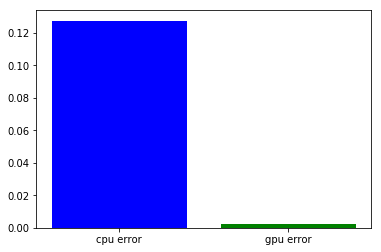

In [15]:
N = 1000000

#source double precision array
d = np.random.rand(N) 

#floating point CPU copy
f = d.astype(np.float32)

#floating point GPU copy
g = gpuarray.to_gpu(f)

#sums
dsum = d.sum()
fsum = f.sum()
gsum = gpuarray.sum(g).get()

#distance from double
ferr = np.abs(dsum-fsum)
gerr = np.abs(dsum-gsum)

print("True sum:", dsum)
print("CPU 32bit precision:", fsum, "error:", ferr)
print("GPU 32bit precision:", gsum, "error:", gerr)

plt.bar(['cpu error','gpu error'], [ferr, gerr], color='bg')
plt.show()

## Example 2: Dot product

For the same reason as we saw in the sum, computing a dot product on a GPU tends to be more accurate in 32bit than on a CPU.

True dot product: 333261.012224
CPU 32bit precision: 333260.0 error: 0.637223520433
GPU 32bit precision: 333261.0 error: 0.0122235204326


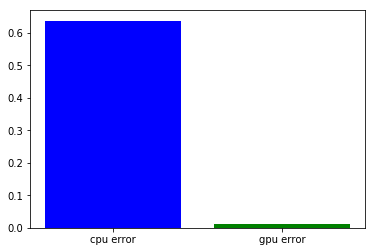

In [16]:
pd = np.dot(d,d)
pf = np.dot(f,f)
pg = gpuarray.dot(g,g).get()

#distance from double
ferr = np.abs(pd-pf)
gerr = np.abs(pd-pg)

print("True dot product:", pd)
print("CPU 32bit precision:", pf, "error:", ferr)
print("GPU 32bit precision:", pg, "error:", gerr)

plt.bar(['cpu error','gpu error'], [ferr, gerr], color='bg')
plt.show()

## Conclusion

And there you have it.  The GPU 32bit solution is quite a bit closer to the true double precision sum than CPU 32bit sum.

Here we have a simple example with a reduction and a dot product, but in reality there are many more examples where we can relax our double precision requirement.